In [1]:
import mxnet as mx
import numpy as np
from mxnet import nd, autograd, gluon
mx.random.seed(1)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\ProgramData\Anaconda3\lib\site-packages\h5py\tests\old\test_attrs_data.py:251: DeprecationWarning: invalid escape sequence \H
  s = b"Hello\x00\Hello"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\func_inspect.py:53: DeprecationWarning: invalid escape sequence \<
  '\<doctest (.*\.rst)\[(.*)\]\>', source_file).groups()
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\_memory_helpers.py:10: DeprecationWarning: invalid escape sequence \s
  cookie_re = re.compile("coding[:=]\s*([-\w.]+)")


In [2]:
data_ctx=mx.gpu()
model_ctx=mx.gpu()
ctx=mx.gpu()

In [3]:
# 创建训练集iter
train_iter = mx.io.ImageRecordIter(
    path_imgrec="image_data_train.rec", 
    data_shape=(3,32,32),
    batch_size=10,
    scale=1/255,
    shuffle=1,
    rand_crop=True,
    rand_mirror=True
    
)

# 创建内部测试集iter
val_iter = mx.io.ImageRecordIter(
    path_imgrec="image_data_test.rec",
    data_shape=(3,32,32),
    batch_size=10,
    scale=1/255,
    shuffle=1
    
)

DataBatch: data shapes: [(10, 3, 32, 32)] label shapes: [(10,)]


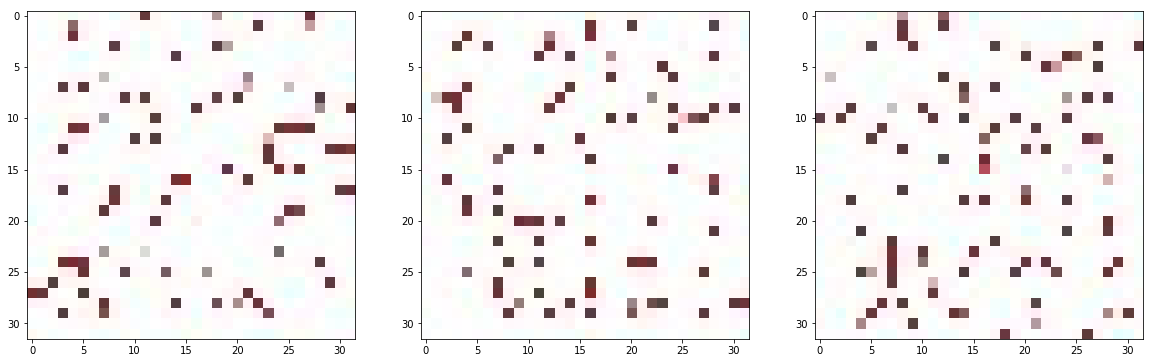

In [5]:
from matplotlib import pyplot as plt
train_iter.reset()
batch = train_iter.next() #
print(batch) 

data = batch.data[0]
fig=plt.figure(0,figsize=(20,20))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow((data[i]*255).asnumpy().astype(np.uint8).transpose((1,2,0)))
    
plt.show()

In [7]:
batch_size=50
num_outputs=4
    

In [ ]:
train_iter.reset()
for data in train_iter:
    print(data)

In [ ]:
train_iter.reset()
for i,batch in enumerate(train_iter):
    print(batch)

In [68]:
train_iter.reset()
test=train_iter.next()
#print(test.data)
label=test.data
label=(label[0]-0.5).as_in_context(ctx)
print(label[0])


[[[ 0.19803923  0.16274512  0.02156866 ...  0.04509807  0.08039218
    0.08823532]
  [ 0.14705884  0.5         0.5        ...  0.5         0.5
    0.3705883 ]
  [ 0.02941179  0.5         0.43725497 ...  0.47647065  0.5
    0.25686282]
  ...
  [ 0.03333336  0.5         0.47647065 ...  0.5         0.5
    0.26470596]
  [ 0.08823532  0.5         0.5        ...  0.5         0.5
    0.31568635]
  [ 0.08431375  0.3588236   0.26470596 ...  0.2607844   0.3196079
    0.15882355]]

 [[-0.39803922 -0.2607843  -0.23725489 ... -0.23725489 -0.24509802
   -0.29215685]
  [-0.27647057  0.4215687   0.47647065 ...  0.46470594  0.4333334
    0.12352943]
  [-0.22941175  0.47647065  0.5        ...  0.5         0.48823535
    0.13529414]
  ...
  [-0.2490196   0.46470594  0.5        ...  0.5         0.4843138
    0.14313728]
  [-0.22941175  0.43725497  0.48823535 ...  0.48823535  0.45294124
    0.14313728]
  [-0.2960784   0.11176473  0.14313728 ...  0.13921571  0.14705884
   -0.07647055]]

 [[-0.4019608  -0.

In [56]:
num_fc=128
net=gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Conv2D(channels=20,kernel_size=5,activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2,strides=2))
    net.add(gluon.nn.Conv2D(channels=50,kernel_size=5,activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2,strides=2))
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(num_fc,activation='relu'))
    net.add(gluon.nn.Dense(num_outputs))

In [57]:
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24),ctx=ctx)

In [58]:
softmax_cross_entropy=gluon.loss.SoftmaxCrossEntropyLoss()

In [59]:
trainer=gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':.1})

In [69]:
def evaluate_accuracy(data_iterator,net):
    acc=mx.metric.Accuracy()
    for batch in (data_iterator):
        data=(batch.data[0]).as_in_context(ctx)
        label=batch.label[0].as_in_context(ctx)
        output=net(data)
        predictions=nd.argmax(output,axis=1)
        #print(predictions)
        #print(label)
        acc.update(preds=predictions,labels=label)
    return acc.get()[1]

In [70]:
epochs=10
smoothing_constant=0.1
for e in range(epochs):
    train_iter.reset()
    val_iter.reset()
    for i, batch in enumerate(train_iter):
        data=(batch.data[0]).as_in_context(ctx)
        #print(data[0])
        label=batch.label[0].as_in_context(ctx)
        with autograd.record():
            output=net(data)
            loss=softmax_cross_entropy(output,label)
        loss.backward()
        trainer.step(data.shape[0])
        curr_loss=nd.mean(loss).asscalar()
        #print(net(data))
        moving_loss=(curr_loss if ((i==0) and (e==0))
                     else(1-smoothing_constant)*moving_loss+smoothing_constant*curr_loss)
    train_iter.reset()
    test_accuracy=evaluate_accuracy(val_iter,net)
    train_accuracy=evaluate_accuracy(train_iter,net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" %(e, moving_loss,train_accuracy,test_accuracy))

Epoch 0. Loss: 1.3894529664759934, Train_acc 0.24536082474226803, Test_acc 0.256
Epoch 1. Loss: 1.3902923548085393, Train_acc 0.24536082474226803, Test_acc 0.26666666666666666
Epoch 2. Loss: 1.3891243152344945, Train_acc 0.25463917525773194, Test_acc 0.22083333333333333
Epoch 3. Loss: 1.390355684642768, Train_acc 0.24742268041237114, Test_acc 0.26666666666666666
Epoch 4. Loss: 1.390765530385787, Train_acc 0.24895833333333334, Test_acc 0.25833333333333336
Epoch 5. Loss: 1.3911639399453837, Train_acc 0.24536082474226803, Test_acc 0.272
Epoch 6. Loss: 1.388080383861184, Train_acc 0.24742268041237114, Test_acc 0.26666666666666666
Epoch 7. Loss: 1.3917990115344683, Train_acc 0.2463917525773196, Test_acc 0.2708333333333333
Epoch 8. Loss: 1.3910018300189633, Train_acc 0.2463917525773196, Test_acc 0.2625
Epoch 9. Loss: 1.3886415260915415, Train_acc 0.246875, Test_acc 0.25833333333333336
